Tutorial 4: Dealing With Failure
================================

In the last tutorial we showed how our non-linear search can potentially fail, and infer a local maxima solution.
In this tutorial, we're going to learn how to stop this and infer the globally maximal lens model.

In the previous tutorial, when we inferred a local maxima we knew that we had done so. For modeling a real lens,
we do not know the 'true' lens model and it iss often  unclear if a solution is a global or local maximma. The tricks
we learn in this tutorial are therefore equally important for verifying that a solution does indeed appear to be the
global maxima.

In [1]:
%matplotlib inline

import numpy as np
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

conf.instance = conf.Config(
    config_path=f"{workspace_path}/howtolens/config",
    output_path=f"{workspace_path}/howtolens/output",
)



Workspace Path:  /home/carlos/autolens_workspace


We’ll use the same strong lensing data as the previous tutorial, where:

    The lens galaxy’s LightProfile is an EllipticalSersic.
    The lens galaxy’s MassProfile is an EllipticalIsothermal.
    The source galaxy’s LightProfile is an EllipticalExponential.


In [2]:
from howtolens.simulators.chapter_2 import (
    lens_sersic_sie__source_exp,
)

dataset_type = "chapter_2"
dataset_name = "lens_sersic_sie__source_exp"
dataset_path = f"{workspace_path}/howtolens/dataset/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)


We’ll create and use a smaller 2.0” Mask again.

In [3]:
mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, radius=2.0
)

When plotted, the lens light’s is clearly visible in the centre of the image.

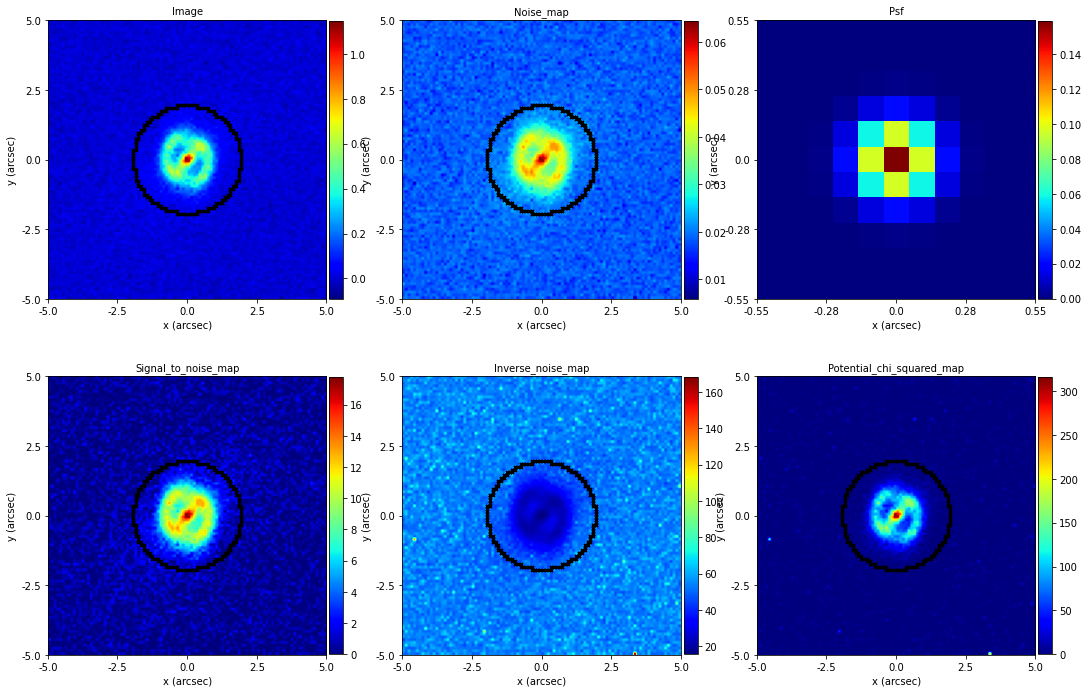

In [4]:
aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

Like in the previous tutorials, we use a_PhaseSettingsImaging_ object to specify our model-fitting procedure uses a regular Grid.

In [5]:
settings = al.PhaseSettingsImaging(grid_class=al.Grid, sub_size=2)

__Approach 1: Prior Tuning__

First, we're going to try giving our non-linear search a helping hand. Lets think about our priors, they're telling 
the non-linear search where to look in parameter space. If we tell it to look in the right place (that is, 
*tune* our priors), it might find the best-fit lens model.

We've already seen that we can fully customize priors in PyAutoLens, so lets do it. I've set up a custom phase 
below and specified a new set of priors that'll give the non-linear search a much better chance if inferring the 
correct model. I've also let you know what we're changing the priors from (as initially specified by the 
'config/priors/default' config files.)

We'll call our lens and source galaxies 'lens' and 'source' this time, for shorter more readable code.

In a later tutorial, we'll cover non-linear search approaches that are different to Dynesty, where one provides the
non-linear search with a 'starting point' where it samples parameter space. In a similar fashion to prior tuning,
giving these searches a good starting point will increase the chances of us finding the global maxima

In [6]:
lens = al.GalaxyModel(
    redshift=0.5, light=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
)

By default, the prior on the (y,x) coordinates of a LightProfile / MassProfile is a GaussianPrior with mean 0.0” and sigma “1.0. However, visual inspection of our strong lens image tells us that its clearly around x = 0.0” and y = 0.0”, so lets reduce where non-linear search looks for these parameters.

In [7]:
lens.light.centre.centre_0 = af.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
lens.light.centre.centre_1 = af.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
lens.mass.centre.centre_0 = af.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
lens.mass.centre.centre_1 = af.UniformPrior(lower_limit=-0.05, upper_limit=0.05)

By default, the elliptical components of the of our lens galaxy’s elliptical LightProfile are UniformPriors between -1.0 and 1.0, corresponding to the full range of possible ellipses with axis-ratio from 0.0 to 1.0 and position angles from 0.0 to 180.0 degrees.

However, looking close to the image it is clear that the lens galaxy’s light is elliptical and oriented around 45.0 degrees counter-clockwise from the x-axis. We can update the priors on our elliptical components to reflect this.

In [8]:
lens.light.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(
    mean=0.333333, sigma=0.1, lower_limit=-1.0, upper_limit=1.0
)
lens.light.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-1.0, upper_limit=1.0
)

Lets additionally assume that the LightProfile’s ellipticity informs us of the MassProfile’s ellipticity. Because this may not strictly be true (e.g. because of dark matter) we’ll use a wider prior.

In [9]:
lens.mass.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(
    mean=0.333333, sigma=0.3, lower_limit=-1.0, upper_limit=1.0
)
lens.mass.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(
    mean=0.0, sigma=0.3, lower_limit=-1.0, upper_limit=1.0
)

The effective radius of a LightProfile is its ‘half-light’ radius, the radius at which 50% of its total luminosity is internal to a circle defined within that radius. PyAutoLens assumes a UniformPrior on this quantity between 0.0” and 4.0”, but inspection of the image (again, using a colormap scaling) shows the lens’s light doesn’t extend anywhere near 4.0”, so lets reduce it.

In [10]:
lens.light.effective_radius = af.GaussianPrior(
    mean=1.0, sigma=0.8, lower_limit=0.0, upper_limit=np.inf
)

Typically, we have knowledge of our lens galaxy’s morphology. Most strong lenses are massive elliptical galaxies which have Sersic indexes near 4. So lets change our Sersic index from a UniformPrior between 0.8 and 8.0 to reflect this.

In [11]:
lens.light.sersic_index = af.GaussianPrior(
    mean=4.0, sigma=1.0, lower_limit=0.0, upper_limit=np.inf
)

Finally, the ‘ring’ that the lensed source forms clearly has a radius of about 1.2”. This is its Einstein radius, so lets change the prior from a UniformPrior between 0.0” and 4.0”.

In [12]:
lens.mass.einstein_radius = af.GaussianPrior(
    mean=1.2, sigma=0.2, lower_limit=0.0, upper_limit=np.inf
)

In this exercise, I’m not going to change any priors on the source galaxy. Whilst lens modeling experts can look at a strong lens and often tell you roughly where the source-galaxy is located (in the source-plane), it is something of art form. Furthermore, the source’s morphology can be pretty complex, making it difficult to come up with a good source prior!

In [13]:
source = al.GalaxyModel(redshift=1.0, light=al.lp.EllipticalExponential)

We can now create this custom phase and run it. Our non-linear search will now start by sampling higher likelihood regions of parameter space, given our improved and more informed priors.

In [15]:
phase = al.PhaseImaging(
    phase_name="phase_t4_custom_priors",
    settings=settings,
    galaxies=dict(lens=lens, source=source),
    search=af.DynestyStatic(n_live_points=50),
)

print(
    "Dynesty has begun running - checkout the workspace/output/4_dealing_with_failure"
    "folder for live output of the results, images and lens model."
    "This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result_custom_priors = phase.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

Dynesty has begun running - checkout the workspace/output/4_dealing_with_failurefolder for live output of the results, images and lens model.This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
153it [00:26,  1.37it/s, bound: 0 | nc: 62 | ncall: 1542 | eff(%):  9.922 | loglstar:   -inf < -11621.211 <    inf | logz: -11628.846 +/-  1.765 | dlogz: 8453.152 >  0.059]  /home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
159it [00:27,  4.03it/s, bound: 1 | nc: 14 | ncall: 1582 | eff(%): 10.051 | loglstar:   -inf < -11218.242 <    inf | logz: -11225.996 +/-  1.766 | dlogz: 8188.750 >  

312it [00:47,  7.73it/s, bound: 23 | nc: 5 | ncall: 2398 | eff(%): 13.011 | loglstar:   -inf < -3707.359 <    inf | logz: -3718.143 +/-  1.800 | dlogz: 1182.953 >  0.059]/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
319it [00:48,  7.17it/s, bound: 24 | nc: 5 | ncall: 2442 | eff(%): 13.063 | loglstar:   -inf < -3570.160 <    inf | logz: -3580.624 +/-  1.791 | dlogz: 1477.529 >  0.059] /home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
324it [00:49,  3.95it/s, bound: 24 | nc: 21 | ncall: 2486 | eff(%): 13.033 | loglstar:   -inf < -3554.280 <    inf | logz: -3564.837 +/-  1.790 | dlogz: 1461.498

641it [00:54, 11.75it/s, +50 | bound: 98 | nc: 1 | ncall: 7600 | eff(%):  9.092 | loglstar:   -inf < 302.762 <    inf | logz: 285.443 +/-  1.883 | dlogz:  1.099 >  0.059]  
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
679it [00:29,  1.50s/it, bound: 113 | nc: 104 | ncall: 8951 | eff(%):  7.586 | loglstar:   -inf < -1648.829 <    inf | logz: -1666.880 +/-  1.878 | dlogz: 1965.861 >  0.059]/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
698it [00:53, 13.13it/s, +50 | bound: 123 | nc: 1 | ncall: 10123 | eff(%):  7.389 | loglstar:   -inf < 350.035 <    inf | logz: 331.588 +/-  1.886 | dlogz:  1.099 >  0.059] 
INFO:root:10000 Iterations: Performing update (Visualization, outputting samples, etc.).
860it [00:52, 16.30it/s, +50 | bound: 164 | nc: 1 | ncall: 126

Dynesty has finished run - you may now continue the notebook.




Bam! We get a good model, which indeed corresponds to the global maxima. By giving our non-linear search a helping hand and informing it of where to sample parameter space, we can increase the odds that we find the global maxima solution.

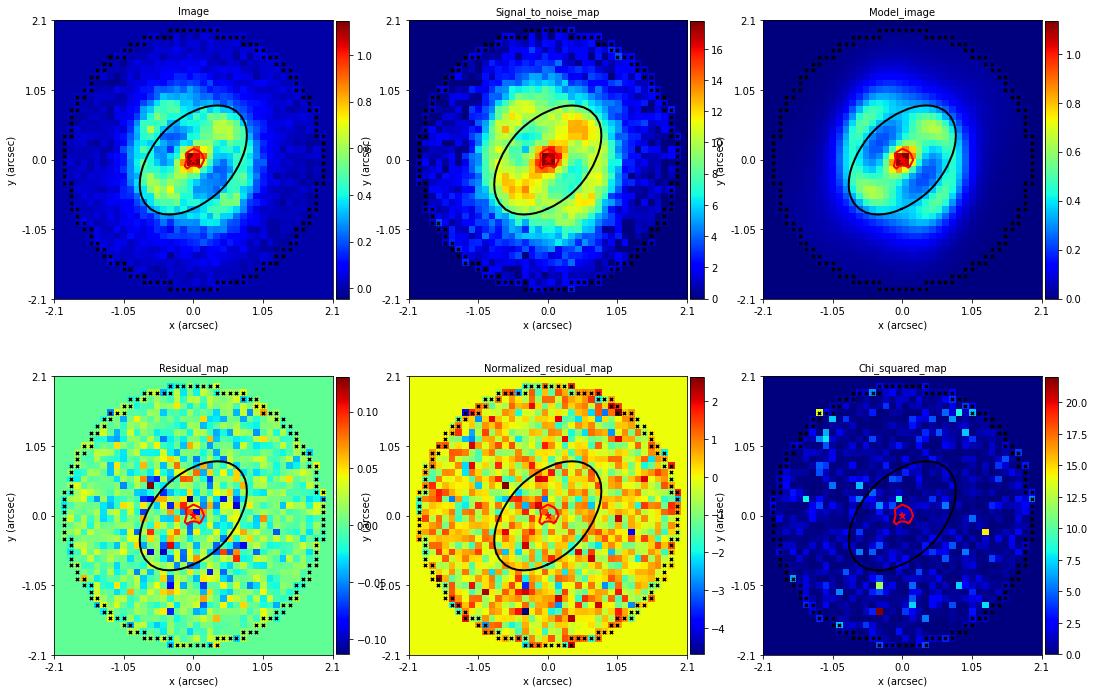

In [16]:
aplt.FitImaging.subplot_fit_imaging(fit=result_custom_priors.max_log_likelihood_fit)

By tuning our priors to the lens we’re fitting we can increase our chance of inferring the global maxima lens model. Before moving onto the next approach, lets think about the advantages and disadvantages of prior tuning:

Advantages:

    We find the maximum log likelihood solution in parameter space.
    The phase took less time to run because the non-linear search explored less of parameter space.

Disadvantages:

    If we specified a prior incorrectly the non-linear search would begin and therefore end at an incorrect solution.
    Our phase was tailored to this specific strong lens. If we want to fit a large sample of lenses we’d have to write a custom phase for every single one - this would take up a lot of our time!


__Approach 2: Reducing Complexity__

Previously, Our non-linear searched failed because we made the lens model more complex. Can we can make it less complex, 
whilst still keeping it fairly realistic? Maybe there are some assumptions we can make to reduce the number of 
lens model parameters and therefore dimensionality of non-linear parameter space?

Well, we can *always* make assumptions. Below, I'm going to create a phase that assumes that light-traces-mass. That 
is, that our _LightProfile_'s centre, and elliptical components are perfectly aligned with its mass. This may, or may 
not, be a reasonable assumption, but it'll remove 4 parameters from the lens model (the _MassProfile_'s y, x, and 
elliptical components), so its worth trying!

In [17]:
lens = al.GalaxyModel(
    redshift=0.5, light=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
)

source = al.GalaxyModel(redshift=1.0, light=al.lp.EllipticalExponential)

In the pass priors function we can ‘pair’ any two parameters by setting them equal to one another. This removes the parameter on the left-hand side of the pairing from the lens model such that is always assumes the same value as the parameter on the right-hand side.

In [18]:
lens.mass.centre = lens.light.centre

Lets do this with the elliptical components of the light and mass profiles.

In [19]:
lens.mass.elliptical_comps = lens.light.elliptical_comps

Again, we create this phase and run it. The non-linear search now has a less complex parameter space to search.

Dynesty has begun running - checkout the workspace/output/4_dealing_with_failurefolder for live output of the results, images and lens model.This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
157it [00:34,  4.38it/s, bound: 2 | nc: 5 | ncall: 1583 | eff(%):  9.918 | loglstar:   -inf < -12044.075 <    inf | logz: -12052.334 +/- 219.727 | dlogz: 4487.653 >  0.049]   /home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
160it [00:34,  4.64it/s, bound: 2 | nc: 8 | ncall: 1609 | eff(%):  9.944 | loglstar:   -inf < -11991.328 <    inf | logz: -11999.660 +/- 219.727 | dlogz: 4420.323 > 

2190it [00:49,  7.05it/s, bound: 486 | nc: 5 | ncall: 19887 | eff(%): 11.012 | loglstar:   -inf < 433.385 <    inf | logz: 379.926 +/- 219.732 | dlogz:  9.233 >  0.049] /home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
2212it [00:55,  3.99it/s, bound: 492 | nc: 16 | ncall: 20164 | eff(%): 10.970 | loglstar:   -inf < 433.939 <    inf | logz: 380.184 +/- 219.732 | dlogz: 14.271 >  0.049]/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
2213it [00:59, 37.12it/s, +40 | bound: 493 | nc: 1 | ncall: 20364 | eff(%): 11.064 | loglstar:   -inf < 449.041 <    inf | logz: 389.995 +/- 219.743 | dlogz:  1.095

Dynesty has finished run - you may now continue the notebook.


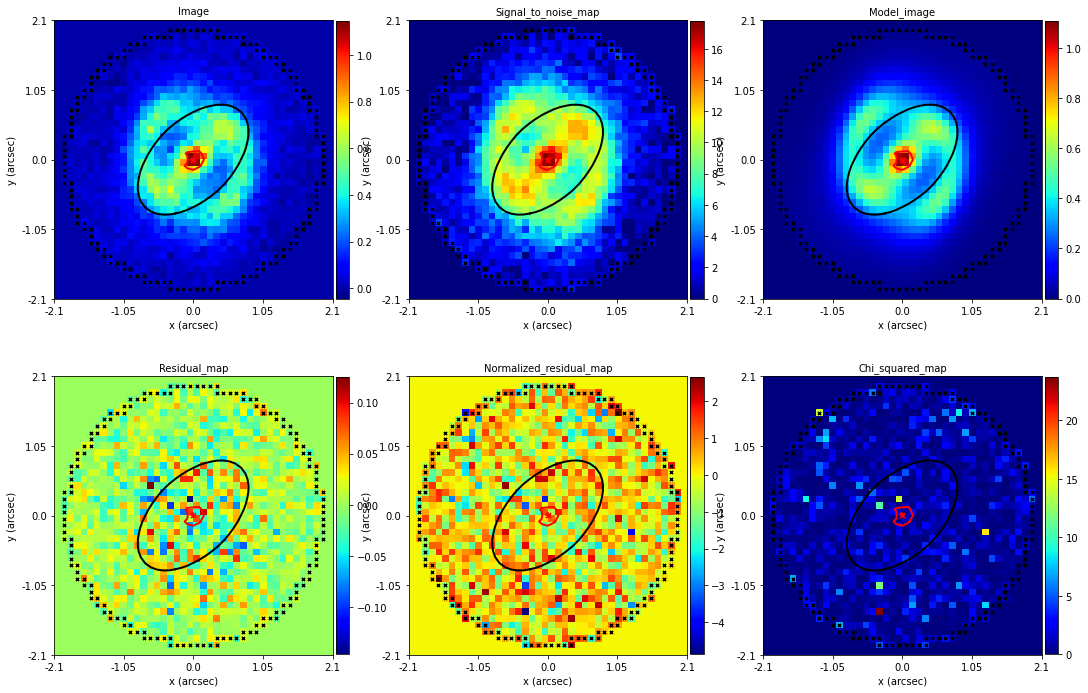

In [20]:
phase_light_traces_mass = al.PhaseImaging(
    phase_name="phase_t4_light_traces_mass",
    settings=settings,
    galaxies=dict(lens=lens, source=source),
    search=af.DynestyStatic(n_live_points=40),
)

print(
    "Dynesty has begun running - checkout the workspace/output/4_dealing_with_failure"
    "folder for live output of the results, images and lens model."
    "This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result_light_trace_mass = phase_light_traces_mass.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

aplt.FitImaging.subplot_fit_imaging(fit=result_light_trace_mass.max_log_likelihood_fit)

The results look pretty good. Our source galaxy fits the data pretty well and we’ve clearly inferred a model that looks similar to the one above. However, inspection of the residuals shows that the fit wasn’t quite as good as the custom-phase above.

It turns out that when I simulated this image light didn’t perfectly trace mass. The LightProfile’s elliptical components were (0.333333, 0.0) whereas the MassProfile’s were (0.25, 0.0). The quality of the fit has suffered as a result and the log likelihood we inferred is lower.

Herein lies the pitfalls of making assumptions - they may make your model less realistic and your fits worse!

Again, lets consider the advantages and disadvantages of this approach:

Advantages:

    By reducing parameter space’s complexity we inferred a global maximum log likelihood.
    The phase is not specific to one lens - we could run it on many strong lens images.

Disadvantages:

    Our model was less realistic and our fit suffered as a result.


__Approach 3: Look Harder__

In approaches 1 and 2 we extended our non-linear search an olive branch and helped it find the highest log likelihood 
regions of parameter space. In approach 3 ,we're going to tell it to just 'look harder'.

Basically, every non-linear search algorithm has a set of parameters that govern how thoroughly it searches parameter 
space. The more thoroughly it looks, the more likely it is that it'll find the global maximum lens model. However, 
the search will also take longer - and we don't want it to take too long to get us a result!

In tutorial 7, we'll discuss non-linear searches in more detail, so we'll defer a detailed discussion of setting up
the non-linear searches until then.

lets list the advantages and disadvantages of simply adjusting the non-linear search:

Advantages:

    Its easy to setup, we simpy change parameter of the non-linear search like n_live_points.
    It generalizes to any strong lens.
    We didn't have to make our model less realistic.

Disadvantage:
 
    Its potentially expensive. Very expensive. For very complex models, the run times can begin to take hours, days, 
    weeks or, dare I say it, months!

So, we can now fit strong lenses with PyAutoLens. And when it fails, we know how to get it to work. I hope you're 
feeling pretty smug. You might even be thinking 'why should I bother with the rest of these tutorials, if I can fit 
strong a lens already'.

Well, my friend, I want you to think about the last disadvantage listed above. If modeling a single lens could really 
take as long as a month, are you really willing to spend your valuable time waiting for this? I'm not, which is why I 
developed PyAutoLens, and in the next tutorial we'll see how we can get the best of both worlds - realistic, complex 
lens model that take mere hours to infer!

Before doing that though, I want you to go over the advantages and disadvantages listed above again and think whether
we could combine these different approaches to get the best of all worlds.